In [1]:
# navigate to http://openinsider.com/ and click through to insider who is selling
# copy & paste url below

In [2]:
# URL from openinsider
# insider = 'Joe Gebbia'
# url = 'http://openinsider.com/insider/Gebbia-Joseph/1834171'

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# URL from http://openinsider.com/
insider = 'Saylor'
url = 'http://openinsider.com/screener?s=&o=1079782&pl=&ph=&ll=&lh=&fd=1461&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=500&page=1'
print (f'fetching insider trades for {insider} at ' + url + '...\n')

fetching insider trades for Saylor at http://openinsider.com/screener?s=&o=1079782&pl=&ph=&ll=&lh=&fd=1461&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=500&page=1...



In [5]:
# there are multiple tables on the webpage
# stock sales info is on table 11

payload=pd.read_html(url)
table = payload[11]
df = table
df = df[::-1]

pd.set_option("display.precision", 2)
# df.columns.values

df.rename(columns = {'Filing\xa0Date':'Filing Date', 'Trade\xa0Date':'Trade Date', 'Insider\xa0Name':'Insider Name', 'Trade\xa0Type':'Trade Type', 'ΔOwn':'Delta Owned'}, inplace = True)
df = df.drop(["X", "1d", "1w", "1m", "6m"], axis=1)
# df.dtypes

In [6]:
df['Price'] = df['Price'].str.strip('$')
df['Price'] = df['Price'].replace( '[\$,)]','', regex=True)
df['Value'] = df['Value'].replace( '[\$,)]','', regex=True)
df['Delta Owned'] = df['Delta Owned'].str.strip('%')
df['Price'] = pd.to_numeric(df['Price'])
df['Qty'] = pd.to_numeric(df['Qty'])
df['Owned'] = pd.to_numeric(df['Owned'])
df['Delta Owned'] = pd.to_numeric(df['Delta Owned'])
df['Delta Owned'] = df['Delta Owned'] / 100
df['Value'] = pd.to_numeric(df['Value'])
df['Proceeds'] = df['Value']*-1 
df['Total Sales'] = df['Proceeds'].cumsum()
df['Trade Date'] = pd.to_datetime(df['Trade Date'])
df['Date'] = pd.to_datetime(df['Trade Date'])
df.set_index('Trade Date', inplace = True)
# df.tail(10)

In [7]:
last_sale = df['Value'].iloc[-1]  # Get the last value in the 'Value' column
# print(f'Last stock sale was for ${last_sale:,.0f}')

In [8]:
ticker = df['Ticker'].values[0]
print(f'fetching {ticker} data')
stock_df = yf.download(ticker)
stock_df = stock_df.drop(columns=['Open','High','Low','Close','Volume'], axis=1)
todays_price = stock_df['Adj Close'].values[-1].round(2)
print(f'yesterdays closing price was ${todays_price}')

fetching MSTR data
[*********************100%***********************]  1 of 1 completed
yesterdays closing price was $1676.85


In [9]:
# merging the two datasets
df = pd.merge(df, stock_df, left_index=True, right_index=True)

In [10]:
df['pX_since'] = todays_price - df['Price']
df['%ch_since'] = (df['pX_since']/df['Price'])*100

In [11]:
# separating out buys and sells into their own dataframes
sells_df = df[df['Proceeds'] > 0]
sells_df['Total Sales'] = sells_df['Proceeds'].cumsum()

In [12]:
# sells_df.tail()

In [13]:
# buys_df = df[df['Proceeds'] < 0]
# buys_df['Proceeds'] = buys_df['Value']
# buys_df['Total Sales'] = buys_df['Proceeds'].cumsum()
# buys_df['Value Now'] = buys_df['Value'] * buys_df['%ch_since']
# # buys_df.tail()

In [14]:
total_sales = df['Total Sales'].iloc[-1]  # Get the last value in the 'Value' column
print(f'{insider} total sales: ${total_sales:,.0f}')

date_labels = sells_df['Date'].tolist()

# Filter the DataFrame for the current year
current_year = datetime.now().year
ytd_df = sells_df[sells_df["Date"].dt.year == current_year]

# Calculate the sum of the "proceeds" column for the YTD period
ytd_proceeds = ytd_df["Proceeds"].sum().round(0)
print(f'{insider} YTD sales: ${ytd_proceeds:,.0f}')

Saylor total sales: $184,278,221
Saylor YTD sales: $184,278,221


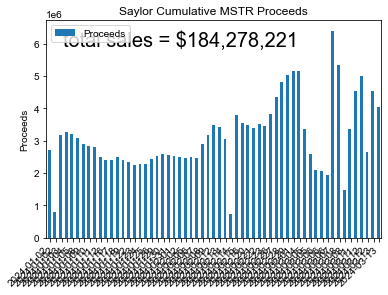

In [15]:
# Assuming 'insider' and 'ticker' are defined elsewhere in your code
proceeds_df = sells_df[['Proceeds']]  # Select the 'Proceeds' column
ax = proceeds_df.plot(kind='bar', stacked=True)
ax.set_title(f'{insider} Cumulative {ticker} Proceeds')  # Update the title
ax.set_ylabel('Proceeds')  # Update the y-axis label

date_labels = sells_df.index.strftime('%Y-%m-%d').tolist()
ax.set_xticks(range(len(date_labels)))
ax.set_xticklabels(date_labels, rotation=45, ha='right')  # Adjust the rotation angle for readability

# Calculate offset for aligning dates with the center of each bar
bar_width = 0.35  # Assuming default bar width
ax.set_xticks([i + bar_width/2 for i in range(len(date_labels))])
ax.set_xticklabels(date_labels)

# adding total sales as text to the plot
ax.text(0.05, 0.95, f'total sales = ${total_sales:,.0f}',
        transform=ax.transAxes, fontsize=20, ha='left', va='top')

plt.style.use('seaborn-darkgrid')
plt.show()  # Add this line to display the plot


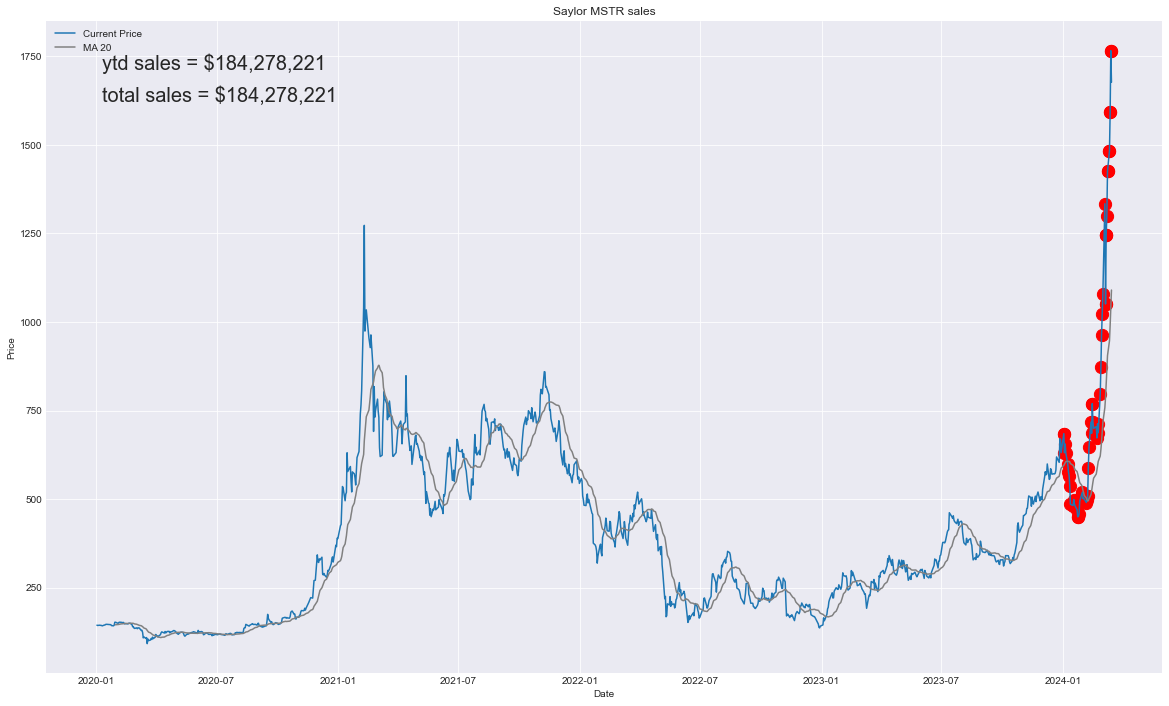

In [16]:
pd.options.mode.chained_assignment = None

# changes default plot size for matplotlib
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [20, 12]

# new plot_df for line-on-close stock chart used below
plot_df = stock_df.loc['2020-1-1':]
sells_df2 = sells_df.loc['2020-1-1':]   

# calculate the 20-day moving average
plot_df['20-day MA'] = plot_df['Adj Close'].rolling(window=20).mean()

# line on close chart and moving average
ax = plt.gca()
ax.plot(plot_df['Adj Close'], label='Current Price') # set the label for the current price
ax.plot(plot_df['20-day MA'], color='gray', label='MA 20') # set the label for the moving average

# gap downs that fill overlay
ax.scatter(x=sells_df2['Date'], y=sells_df2['Adj Close'], color='red', s=150)


# Add YTD sales as text inside the plot
ytd_proceeds_str = '${:,.0f}'.format(ytd_proceeds)
ax.text(0.05, 0.95, f'ytd sales = {ytd_proceeds_str}',
        transform=ax.transAxes, fontsize=20, ha='left', va='top')
# adding total sales as text inside the plot
ax.text(0.05, 0.90, f'total sales = ${total_sales:,.0f}',
        transform=ax.transAxes, fontsize=20, ha='left', va='top')

# setting titles and legend
plt.title(f"{insider} {ticker} sales")
plt.xlabel('Date')
plt.ylabel('Price')
ax.legend()

plt.show(); # Display the plot